# 6.6 Federal Reserve Economic Data (Income) - Time Series -NK 

This script contains the following:
1. Importing your libraries and data
2. Subsetting, wrangling, and cleaning time-series data
3. Time series analysis: decomposition
4. Testing for stationarity
5. Stationarizing the Federal Reserve Economic Data

## 1. Importing libraries and data¶

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
# Configure API Key
quandl.ApiConfig.api_key = 'XkEv3puCj3XWbno2oJVJ'

In [3]:
#importing the following code from Quandl 
data = quandl.get('FRED/DSPIC96')

In [4]:
data.head()

,Value
Date,
1959-01-01,2191.5
1959-02-01,2198.1
1959-03-01,2210.7
1959-04-01,2225.0
1959-05-01,2237.1


In [5]:
data.shape

(756, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

### 2. Subsetting, wrangling, and cleaning time-series data

In [8]:
# check for missing values 
data.isnull().sum() 

# none found

Value    0
dtype: int64

In [9]:
# Check for duplicates

dups = data.duplicated()
dups.sum()

# there are 5

5

In [10]:
# drop duplicates
data.drop_duplicates()

,Value
Date,
1959-01-01,2191.5
1959-02-01,2198.1
1959-03-01,2210.7
1959-04-01,2225.0
1959-05-01,2237.1
...,...
2021-08-01,15712.4
2021-09-01,15458.1
2021-10-01,15432.6


In [11]:
# create data frame not including duplicates
data_no_dups=data.drop_duplicates()

In [12]:
# check shape of subset (5 less)
data_no_dups.shape

(751, 1)

In [13]:
# check for dups  (there are none)
dups = data_no_dups.duplicated()
dups.sum()

0

### 3. Time-series analysis: decomposition

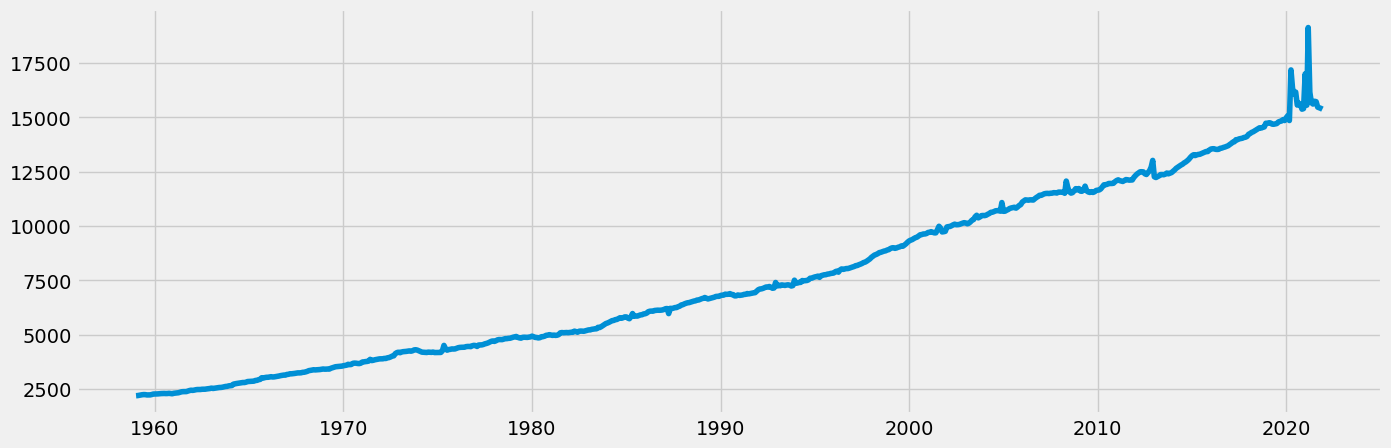

In [15]:
# Plot a line chart

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_no_dups)
plt.savefig('line_chart_time_series.png')

In [16]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [17]:
data_2.head()

,Date,Value
0,1959-01-01,2191.5
1,1959-02-01,2198.1
2,1959-03-01,2210.7
3,1959-04-01,2225.0
4,1959-05-01,2237.1


In [18]:
#I decided to change the date from June to April (I looked up when Covid impacted the economy).
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2020-04-01')]

This is right where my spike is on the line graph. When I attempted in include through June, there was still a very large spike on my line chart.  Therefore, I went back and adjusted to April.

In [19]:
data_sub.shape

(483, 2)

In [20]:
data_sub.head()

,Date,Value
252,1980-01-01,4930.4
253,1980-02-01,4904.0
254,1980-03-01,4873.2
255,1980-04-01,4867.9
256,1980-05-01,4850.1


In [21]:
# check for dups  (there are none)
dups = data_sub.duplicated()
dups.sum()

0

In [22]:
# Check for missing values (none)
data_sub.isnull().sum() 

Date     0
Value    0
dtype: int64

In [23]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-01-01,4930.4
1980-02-01,4904.0
1980-03-01,4873.2
1980-04-01,4867.9
1980-05-01,4850.1


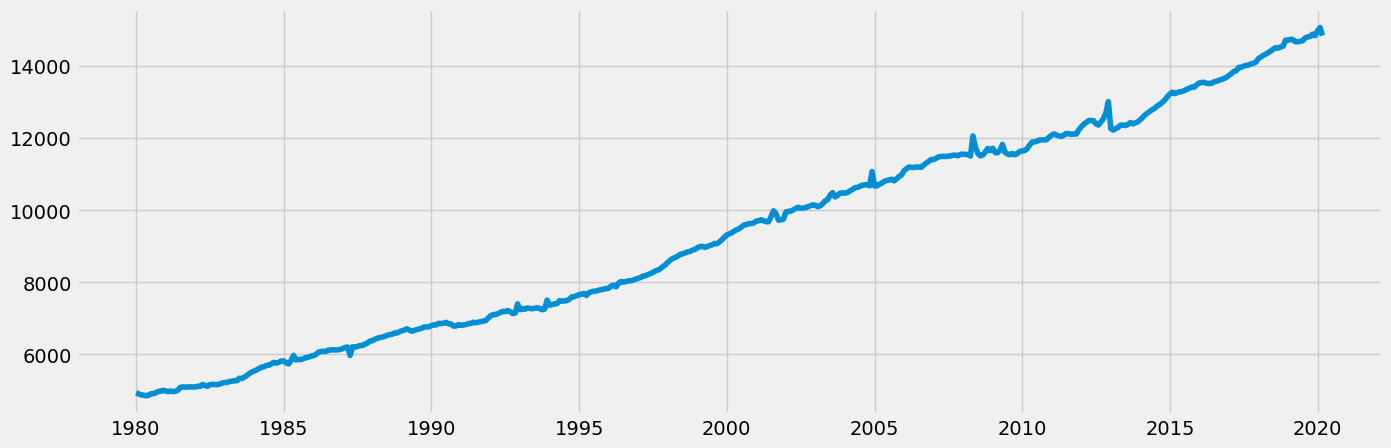

In [25]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)
plt.savefig('line_chart_datetime.png')

This now shows a more steady line, removing the noise that was created during and immediately following the covid pandemic (after April 2020).

### 3. Time-series analysis: decomposition

In [26]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [27]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

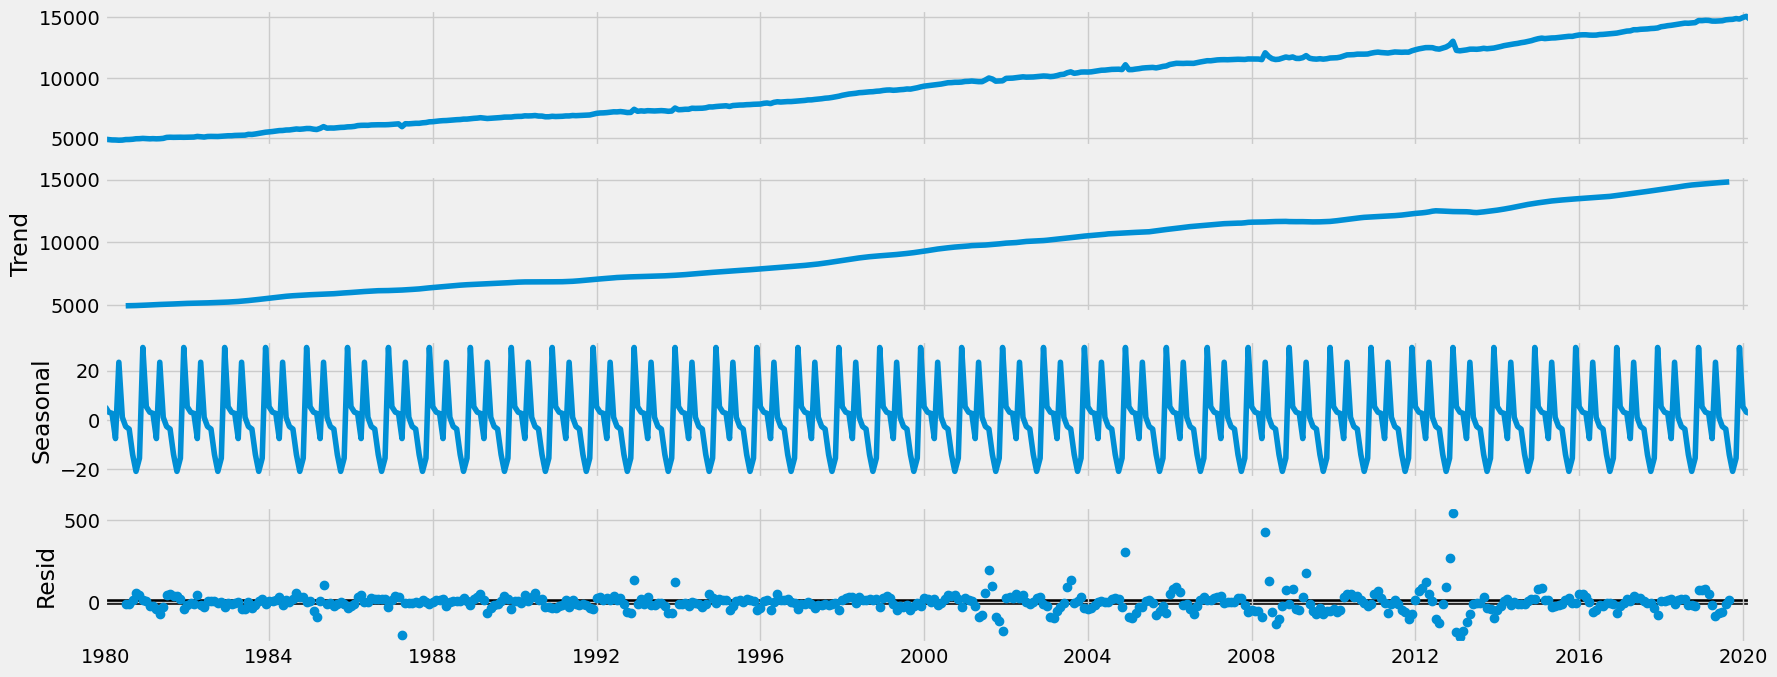

In [29]:
# Plot the separate components

decomposition.plot()
plt.savefig('decomposition.png')
plt.show()

This shows that the trend is very similar to the original data since there is not too much noise (shown in the lowest line, where some occasional outliers are displayed)

### 4. Testing for stationarity

In [30]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only 
# return an array of numbers. This is why you need to also define a function that prints the correct output from 
# that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   1.872917
p-value                          0.998483
Number of Lags Used              4.000000
Number of Observations Used    478.000000
Critical Value (1%)             -3.444105
Critical Value (5%)             -2.867606
Critical Value (10%)            -2.570001
dtype: float64


##### The Dickey-Fuller Test is a statistical test checking for the presence of a unit root (or random jump that can't be explained by variation in the data).  If there was a jump that was not constant, it would make it non-stationary.

##### Remember *To disprove the null hypothesis = no unit root = stationary data = can proceed with forecast.

##### Test statistic of 1.87 is larger than the critical values so we CAN'T REJECT THE NULL.
##### The p-value is .99 which is larger than .05, meaning the test is not significant.

##### This test proves that the data is NON-STATIONARY.  We need to make it stationary.



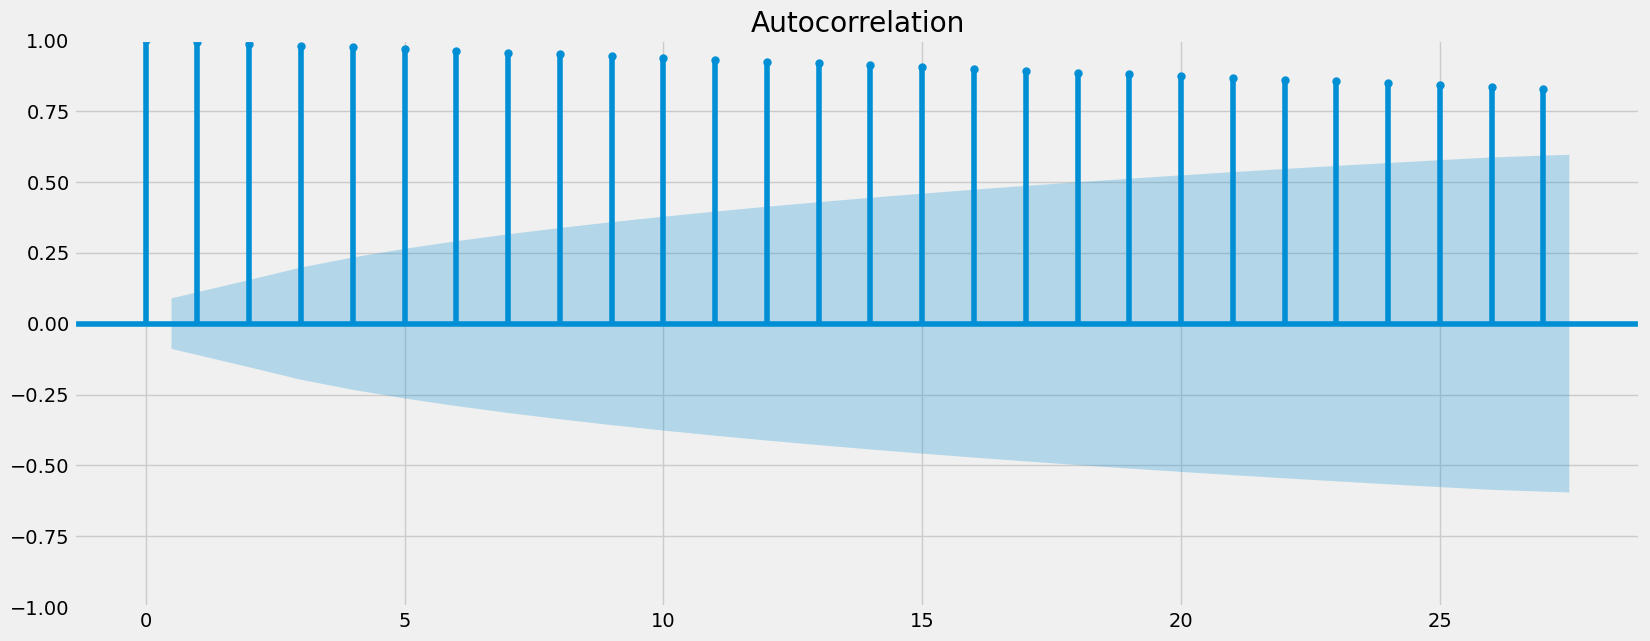

In [32]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
# Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.savefig('autocorrelation.png')
plt.show()

##### The vertical lines represent the lags in the series and the blue area represents the confidence interval.  Since I have proven that the data has a trend (NON-STATIONARY), and I therefore cannot forecast with this.  I will continue on to try and make it stationary.

### 5. Stationarizing the Federal Reserve Economic Data

In [33]:
data_diff = data_sub - data_sub.shift(1) 

# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [34]:
data_diff.dropna(inplace = True) 

# Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [35]:
data_diff.head()

,Value
datetime,
1980-02-01,-26.4
1980-03-01,-30.8
1980-04-01,-5.3
1980-05-01,-17.8
1980-06-01,10.5


In [36]:
data_diff.columns

Index(['Value'], dtype='object')

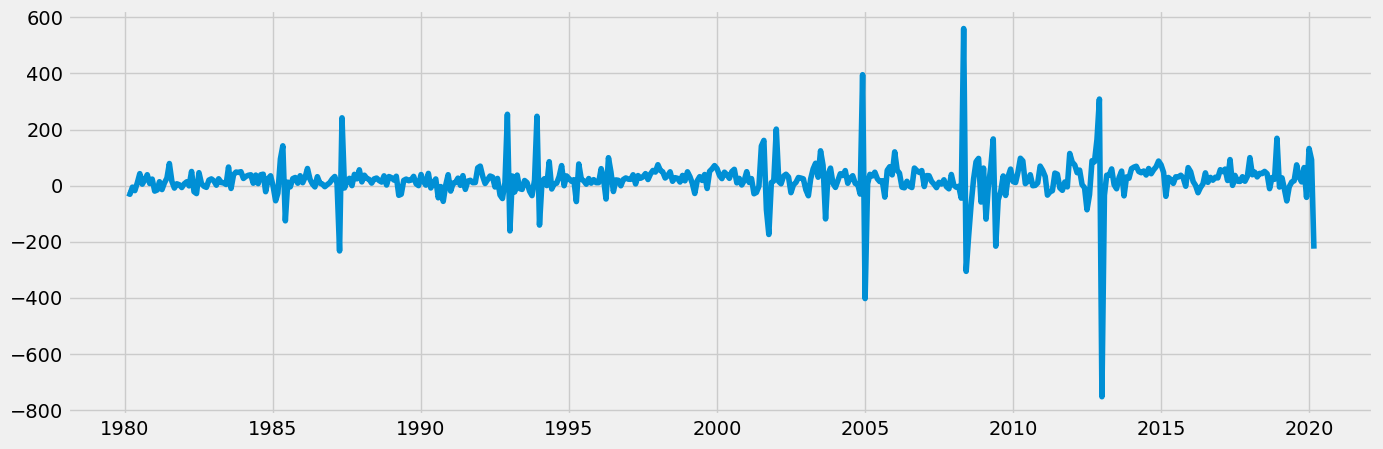

In [38]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)
plt.savefig('differencing.png')
plt.show()

In [39]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -1.510581e+01
p-value                        7.822335e-28
Number of Lags Used            3.000000e+00
Number of Observations Used    4.780000e+02
Critical Value (1%)           -3.444105e+00
Critical Value (5%)           -2.867606e+00
Critical Value (10%)          -2.570001e+00
dtype: float64


##### Test statistic of 1.87 changed to -1.5, which is now larger than the critical values so we CAN REJECT THE NULL.
##### The p-value of .99 changed to 7.8 which is much larger than .05, meaning the test is not significant.

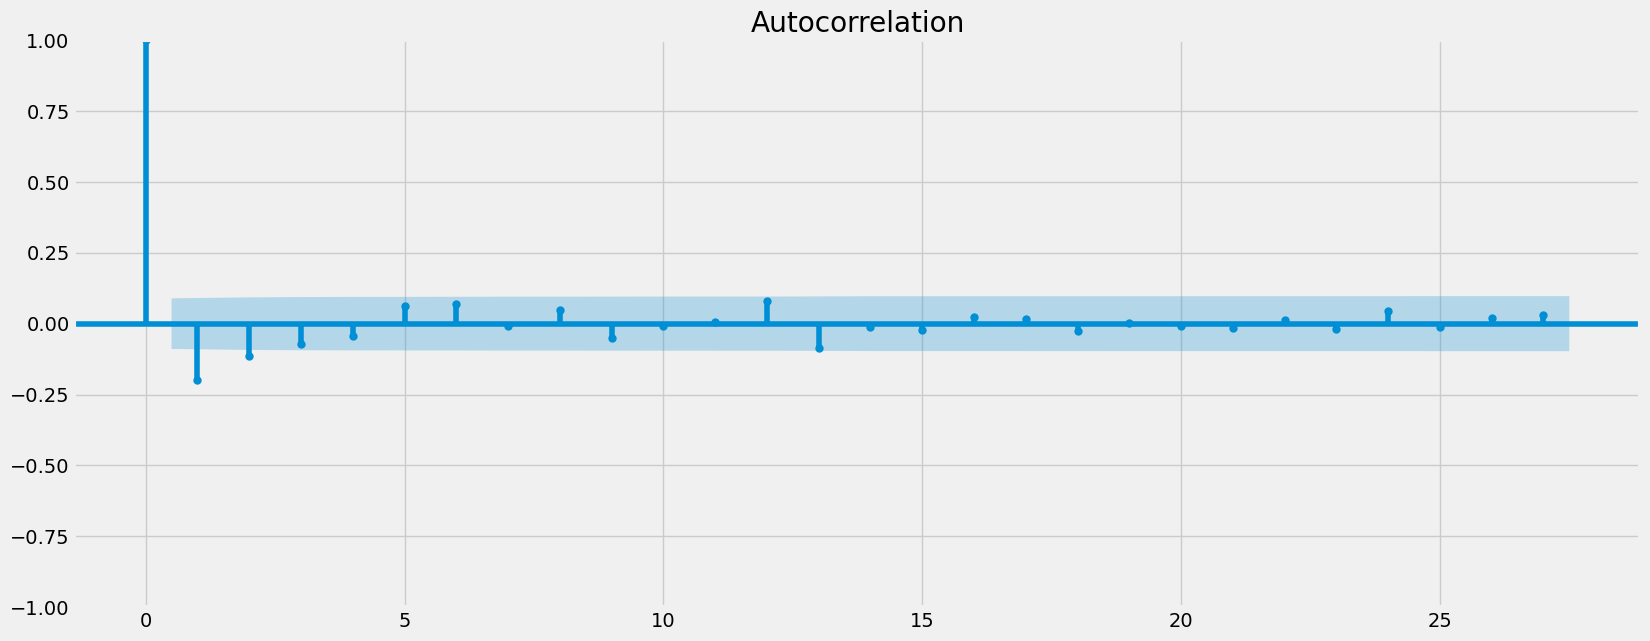

In [40]:
plot_acf(data_diff)
plt.savefig('data_diff_autocorrelation.png')
plt.show()

##### let's try again to conduct another round of differencing to stationarize it further and reduce the remaining autocorrelated terms.

In [41]:
# Check for missing values (none)
data_diff.isnull().sum() 

Value    0
dtype: int64

In [42]:
# I will try differencing again
data_diff_2 = data_diff - data_diff.shift(1) 


In [43]:
data_diff_2.dropna(inplace = True) 

# Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [44]:
data_diff_2.head()

,Value
datetime,
1980-03-01,-4.4
1980-04-01,25.5
1980-05-01,-12.5
1980-06-01,28.3
1980-07-01,32.3


In [45]:
data_diff_2.columns

Index(['Value'], dtype='object')

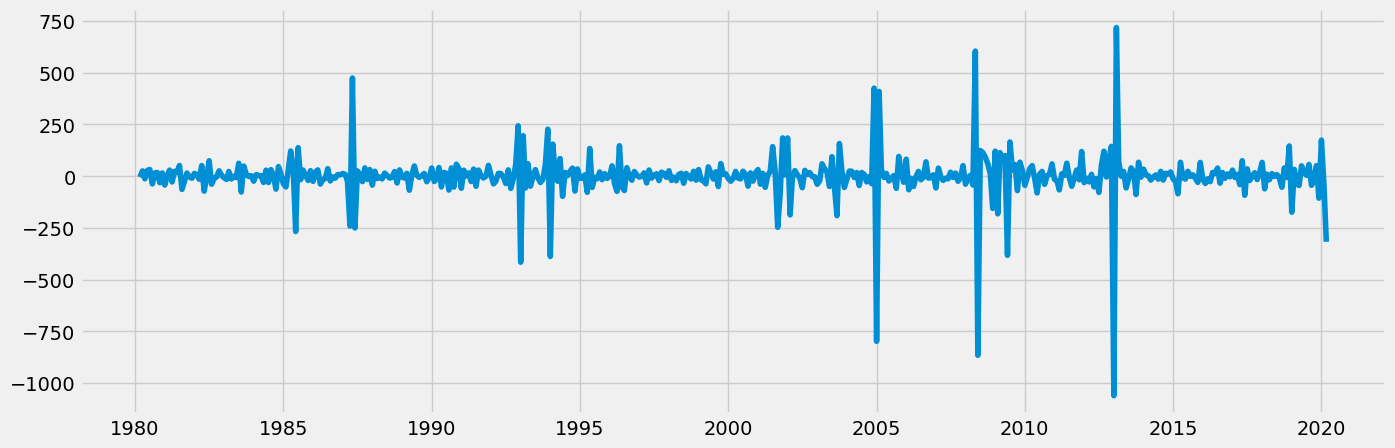

In [47]:
# Check out what the differencing again did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_2)
plt.savefig('data_diff_2')
plt.show()

In [48]:
dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                -1.279597e+01
p-value                        6.915049e-24
Number of Lags Used            1.000000e+01
Number of Observations Used    4.700000e+02
Critical Value (1%)           -3.444340e+00
Critical Value (5%)           -2.867709e+00
Critical Value (10%)          -2.570056e+00
dtype: float64


##### Test statistic of -1.5 changed to -1.3, which is still larger than the critical values so we CAN REJECT THE NULL.
##### The p-value of 7.8 changed to 6.9  which is less but still much larger than .05, meaning the test is not significant.

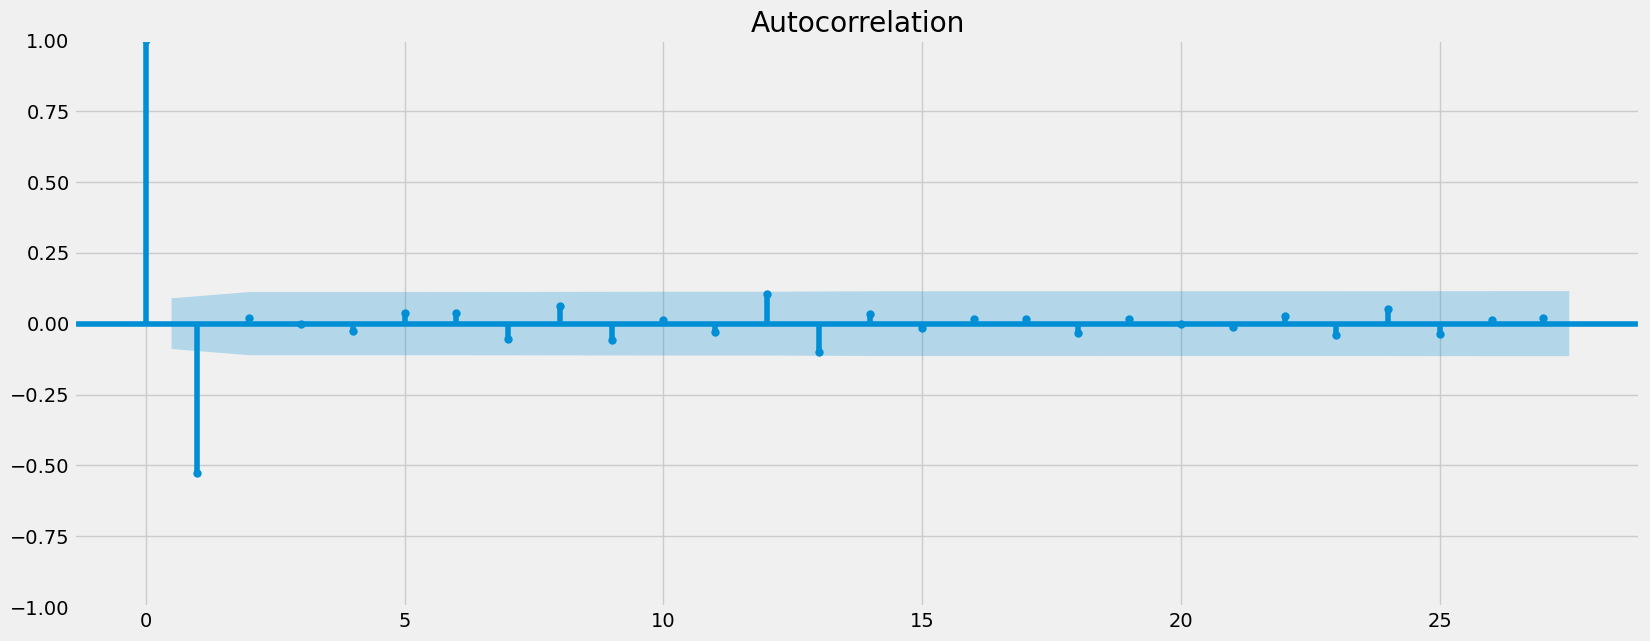

In [49]:
plot_acf(data_diff_2)
plt.savefig('data_diff_2_autocorrelation')
plt.show()

This gives more trend to the dataset (note this by looking at the autocorrelation plot for lag=1 in the second plot). The autocorrelation plot uses the shading to signify where the statistically significant boundary is, so as long as most of the autocorrelation results are close to that shaded region, no need for further differencing.

I continued to see what happens with the data (out of curiosity):

In [50]:
# I will try differencing again.
data_diff_3 = data_diff_2 - data_diff_2.shift(1) 

In [51]:
data_diff_3.dropna(inplace = True) 

# Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [52]:
data_diff_3.head()

,Value
datetime,
1980-04-01,29.9
1980-05-01,-38.0
1980-06-01,40.8
1980-07-01,4.0
1980-08-01,-69.8


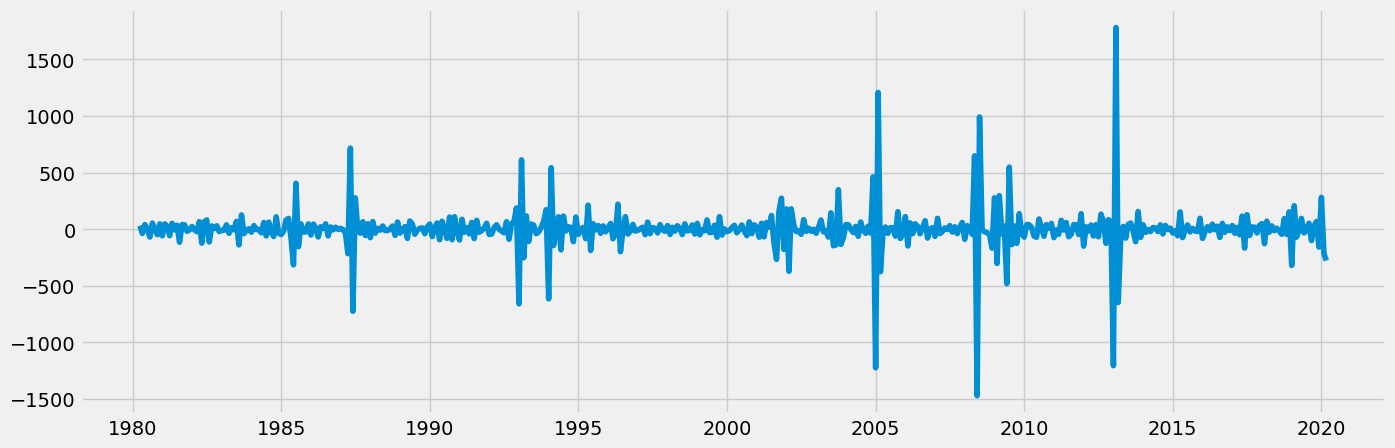

In [53]:
# Check out what the differencing again did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_3)

In [54]:
# run Dickey-Fuller again
dickey_fuller(data_diff_3)

Dickey-Fuller Stationarity test:
Test Statistic                -1.045569e+01
p-value                        1.400630e-18
Number of Lags Used            1.800000e+01
Number of Observations Used    4.610000e+02
Critical Value (1%)           -3.444615e+00
Critical Value (5%)           -2.867830e+00
Critical Value (10%)          -2.570120e+00
dtype: float64


##### Test statistic of -1.3 changed to -1.04, which is still larger than the critical values so we CAN REJECT THE NULL.
##### The p-value of 6.9 changed to 1.4  which is much less but still larger than .05, meaning the test is not significant.
##### Let's try differencing again

In [55]:
# I will try differencing again.
data_diff_4 = data_diff_3 - data_diff_3.shift(1) 

In [56]:
data_diff_4.dropna(inplace = True) 

# Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [57]:
data_diff_4.head()

,Value
datetime,
1980-05-01,-67.9
1980-06-01,78.8
1980-07-01,-36.8
1980-08-01,-73.8
1980-09-01,123.3


In [58]:
# just curious what the shape is after all of the differencng so far
# 483 was the original amount after adjustment - only dropped a few rows.
data_diff_4.shape

(479, 1)

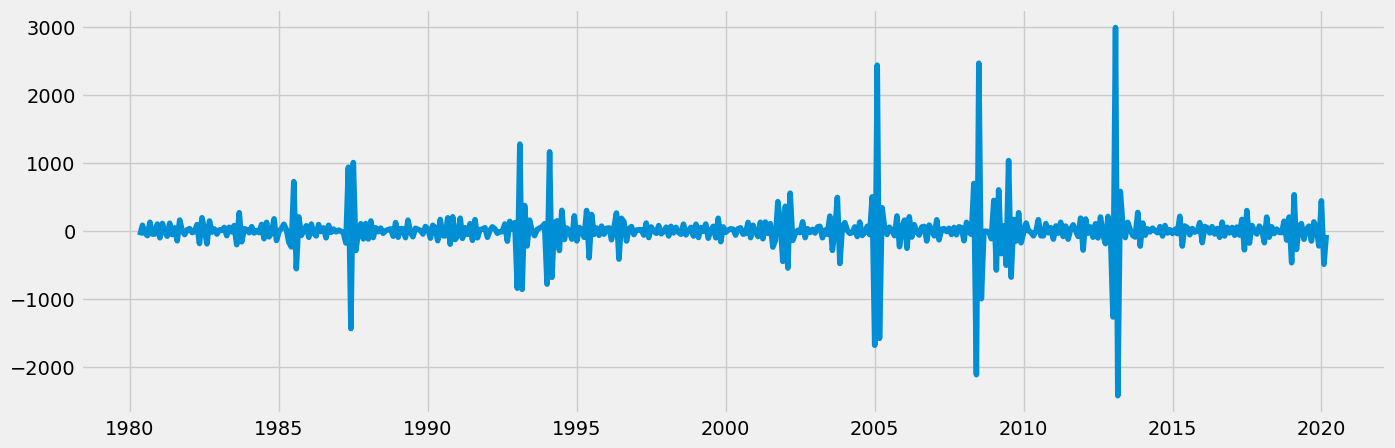

In [59]:
# Check out what the differencing again did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_4)

In [60]:
# run Dickey-Fuller again
dickey_fuller(data_diff_4)

Dickey-Fuller Stationarity test:
Test Statistic                -1.319334e+01
p-value                        1.132352e-24
Number of Lags Used            1.800000e+01
Number of Observations Used    4.600000e+02
Critical Value (1%)           -3.444646e+00
Critical Value (5%)           -2.867844e+00
Critical Value (10%)          -2.570128e+00
dtype: float64


##### Test statistic of -1.04 changed to -1.31, which is still larger than the critical values so we CAN REJECT THE NULL.
##### The p-value of 1.4 changed to 1.13  which is slightly less but still larger than .05, meaning the test is not significant.
##### Let's try differencing one more time

In [61]:
# I will try differencing again.
data_diff_5 = data_diff_4 - data_diff_4.shift(1) 

In [62]:
data_diff_5.dropna(inplace = True) 

# Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [63]:
#check shape (1 less so one was dropped due to differencing)
data_diff_5.shape

(478, 1)

In [64]:
data_diff_5.head()

,Value
datetime,
1980-06-01,146.7
1980-07-01,-115.6
1980-08-01,-37.0
1980-09-01,197.1
1980-10-01,-175.2


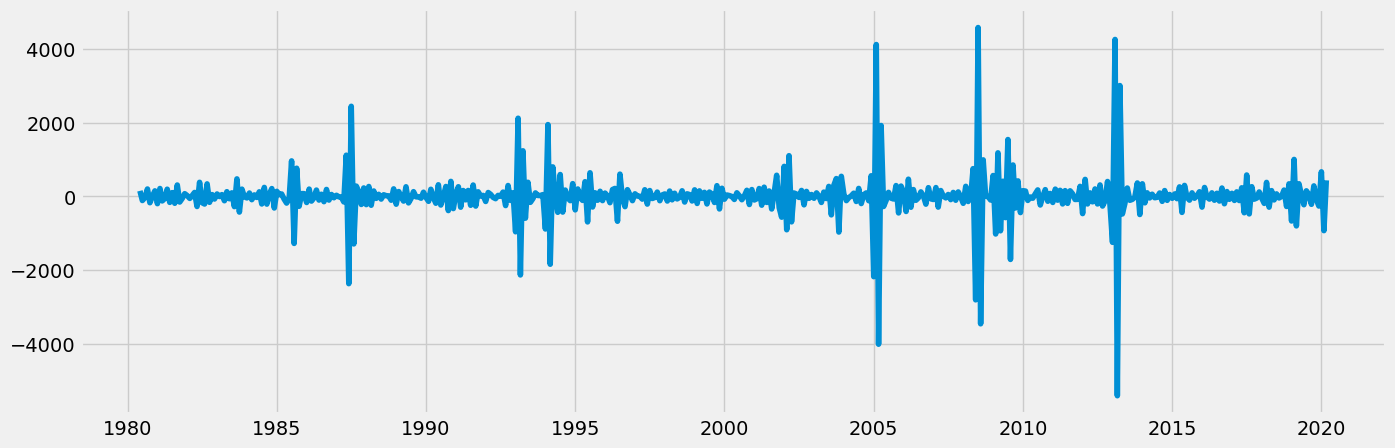

In [65]:
# Check out what the differencing again did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_5)

In [66]:
# run Dickey-Fuller again
dickey_fuller(data_diff_5)

Dickey-Fuller Stationarity test:
Test Statistic                -1.554188e+01
p-value                        2.154108e-28
Number of Lags Used            1.800000e+01
Number of Observations Used    4.590000e+02
Critical Value (1%)           -3.444677e+00
Critical Value (5%)           -2.867857e+00
Critical Value (10%)          -2.570135e+00
dtype: float64


##### Test statistic of -1.31 changed to -1.55, which is still larger than the critical values so we CAN REJECT THE NULL.
##### The p-value of 1.13 changed to 2.15  which is getting larger, sill greater than .05, meaning the test is not significant.
##### At this point, I don't know that I will be able to stationarize the data.



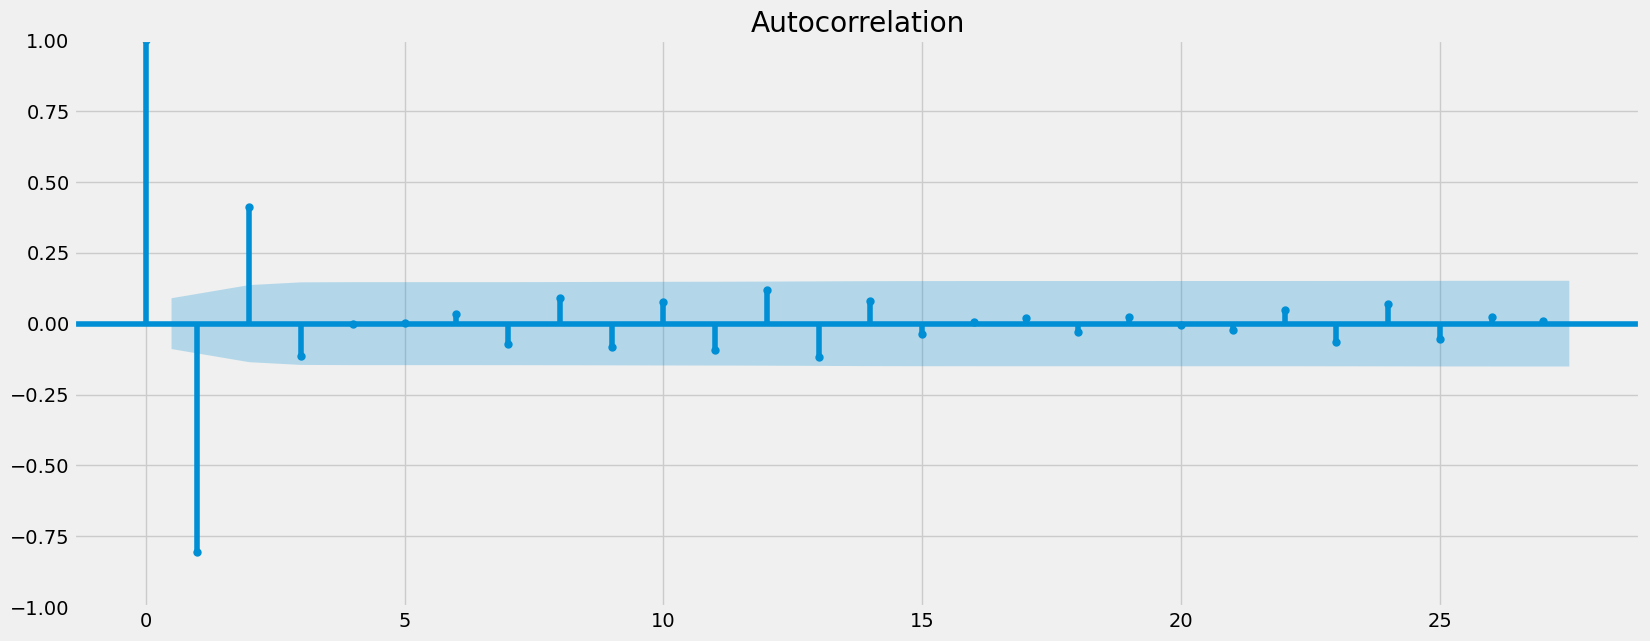

In [67]:
plot_acf(data_diff_5)
plt.show()

##### ONE LAST TRY

In [68]:
# I will try last differencing attempt.
data_diff_6 = data_diff_5 - data_diff_5.shift(1) 

In [69]:
data_diff_6.dropna(inplace = True) 

In [70]:
data_diff_6.shape # (we dropped another row)

(477, 1)

In [71]:
data_diff_6.head()

,Value
datetime,
1980-07-01,-262.3
1980-08-01,78.6
1980-09-01,234.1
1980-10-01,-372.3
1980-11-01,176.6


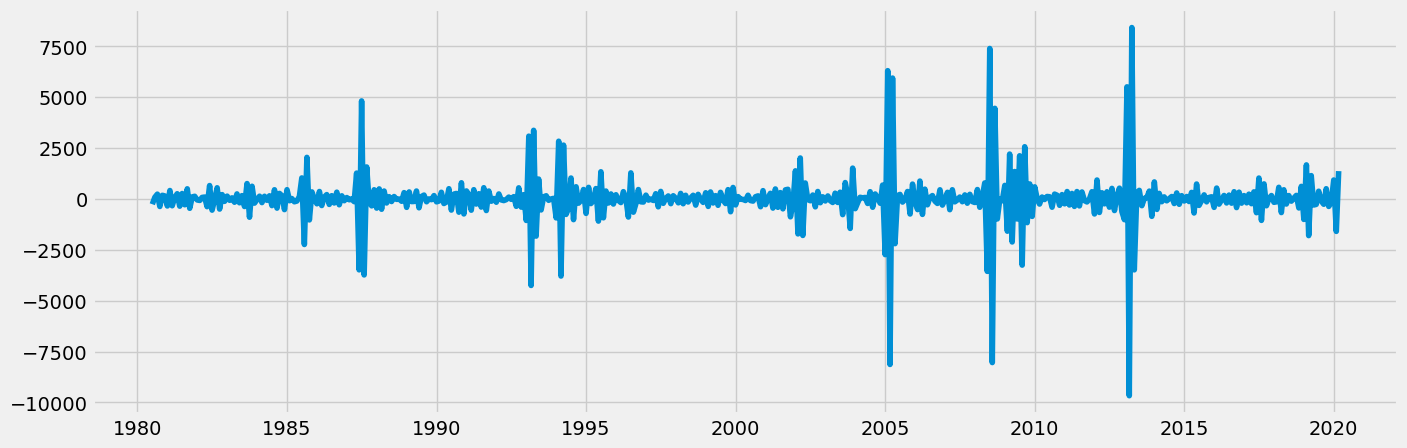

In [72]:
# Check out what the differencing again did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_6)

In [73]:
# run Dickey-Fuller again
dickey_fuller(data_diff_6)

Dickey-Fuller Stationarity test:
Test Statistic                -1.758236e+01
p-value                        4.001435e-30
Number of Lags Used            1.800000e+01
Number of Observations Used    4.580000e+02
Critical Value (1%)           -3.444709e+00
Critical Value (5%)           -2.867871e+00
Critical Value (10%)          -2.570142e+00
dtype: float64


##### The p-value keeps increasing now so the test would show to have a low significance level, even thought he test statistic is is consistently larger than the critical values.  

#### In summary, the data is stationary buth as a very low significance level.

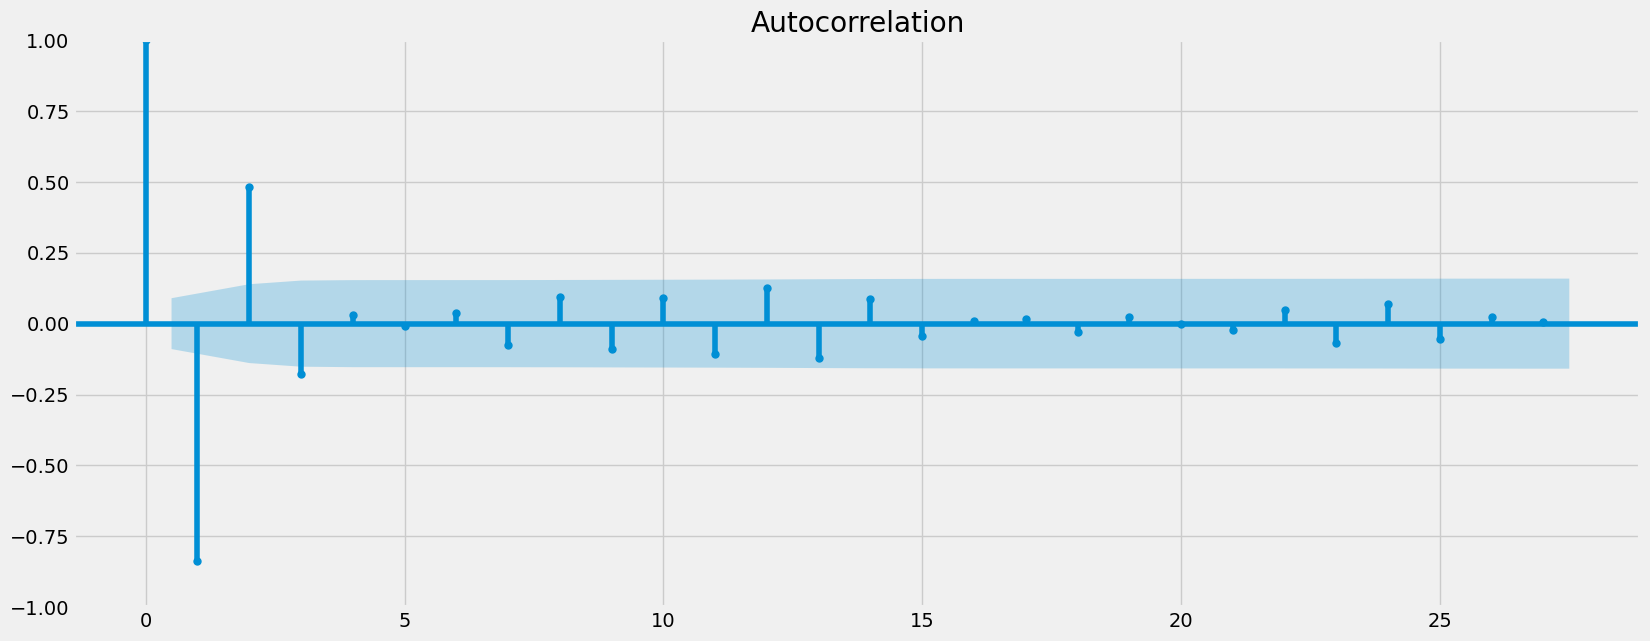

In [74]:
plot_acf(data_diff_6)
plt.show()

## Bonus Task

In [75]:
# Reset index so that you can use the "Date" column as a filter

# I am choosing to use the data_diff_4 subset because it had the lowest p-value of p-value 1.13 in all my attempts
# -it also had good test statistic

data_4 = data_diff_4.reset_index()

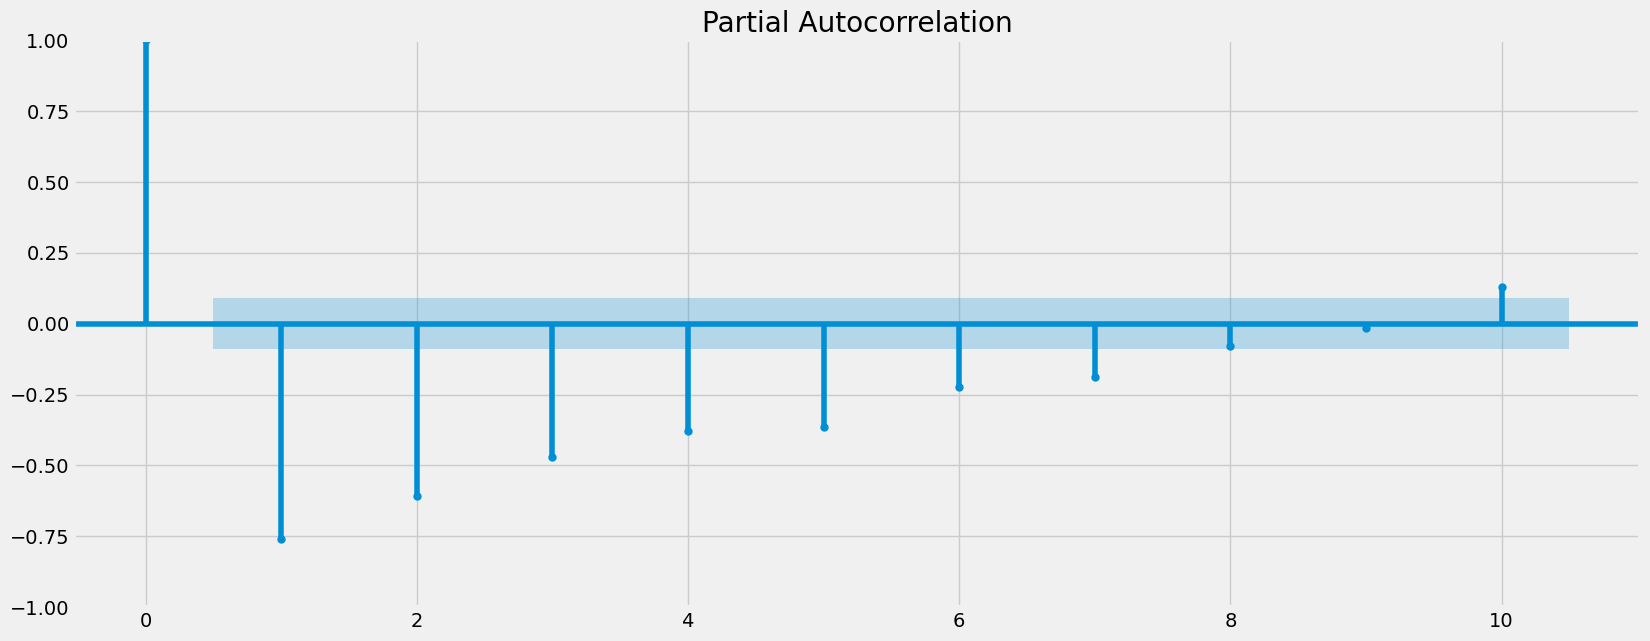

<Figure size 4500x4500 with 0 Axes>

In [78]:
# Plot partial autocorrelations to determine parameter p  (2?)

plot_pacf(data_4['Value'], lags=10)  # Adjust the number of lags as needed
plt.figure(figsize=(15, 15), dpi=300)
plt.savefig('partial_autocorrelation.png')
plt.show()

In [79]:
data_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479 entries, 0 to 478
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  479 non-null    datetime64[ns]
 1   Value     479 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.6 KB


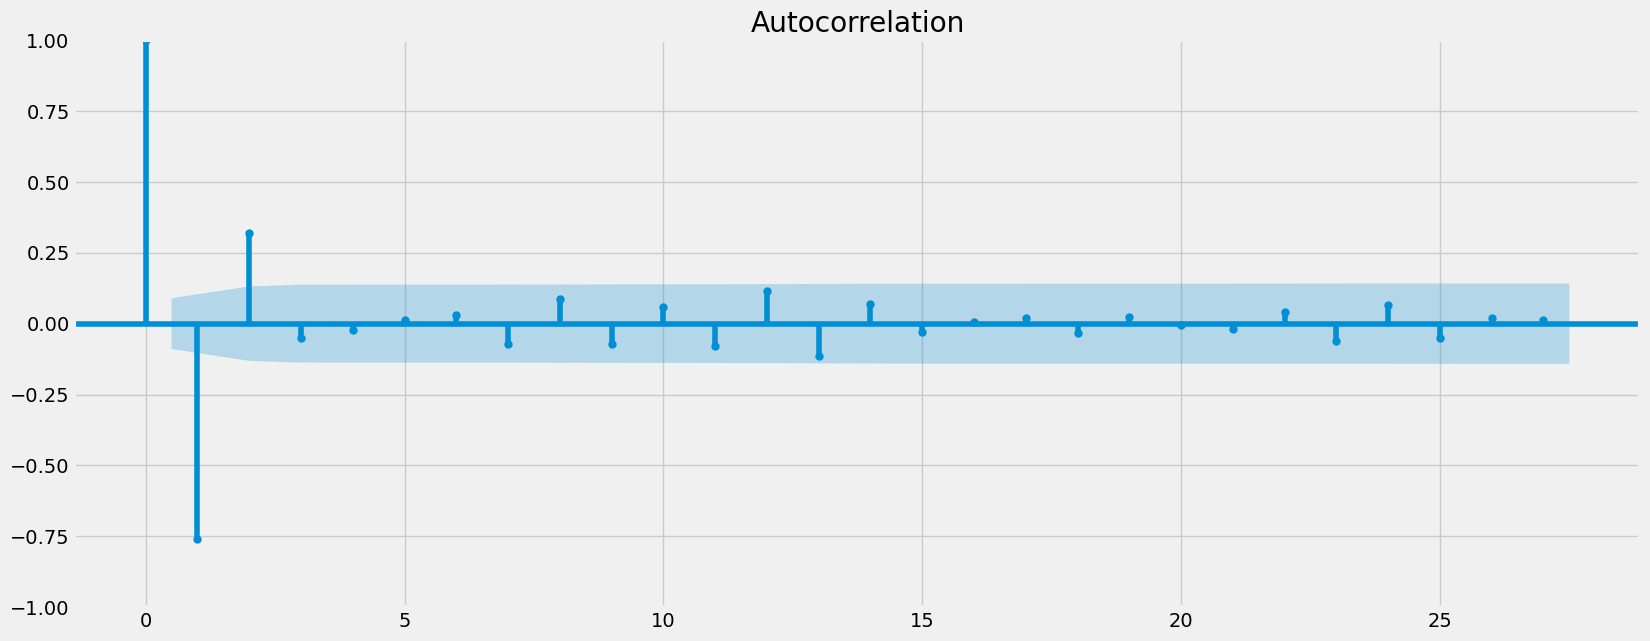

In [80]:
plot_acf(data_diff_4)
plt.show()

In [81]:
data_diff_4.shape

(479, 1)

In [82]:
# Split the data 70/30 or 80/20 split

train = data_diff_4['Value'][:68]
test = data_diff_4['Value'][:411]

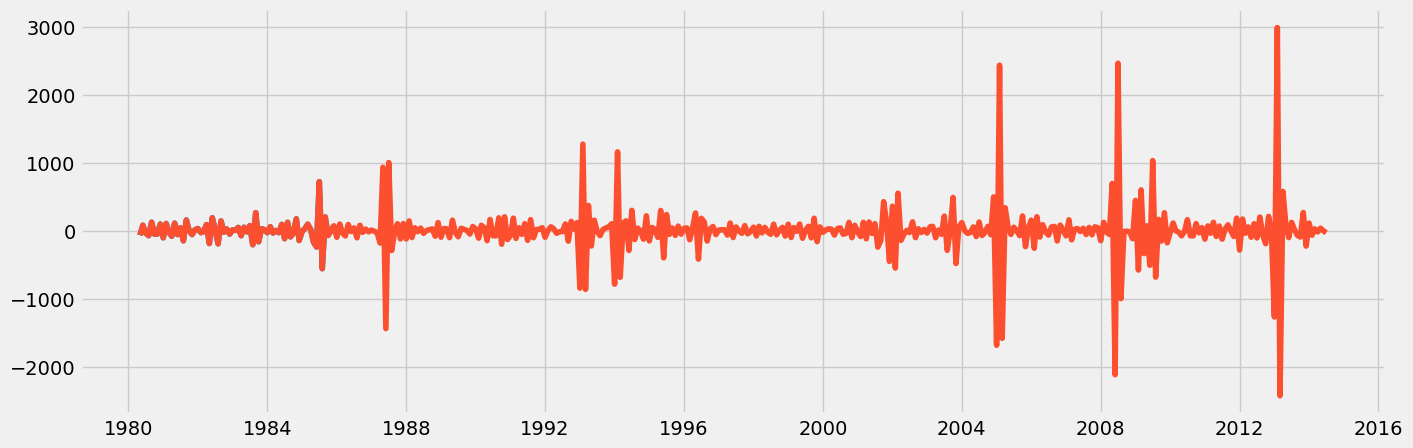

In [83]:
# Plot both sets in order to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)
plt.savefig('split_data')
plt.show()

In [84]:
test.shape

(411,)

In [85]:
train.shape

(68,)

### Run and fit the model

In [86]:
# Import the model you need
from statsmodels.tsa.api import ARIMA 

In [87]:
from statsmodels.tsa.arima_model import ARMA

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   68
Model:                 ARIMA(2, 4, 3)   Log Likelihood                -422.563
Date:                Sun, 11 Aug 2024   AIC                            857.125
Time:                        20:23:09   BIC                            870.078
Sample:                    05-01-1980   HQIC                           862.228
                         - 12-01-1985                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2014      0.105    -11.461      0.000      -1.407      -0.996
ar.L2         -0.6099      0.109     -5.576      0.000      -0.824      -0.395
ma.L1         -2.9446      0.307     -9.578      0.0

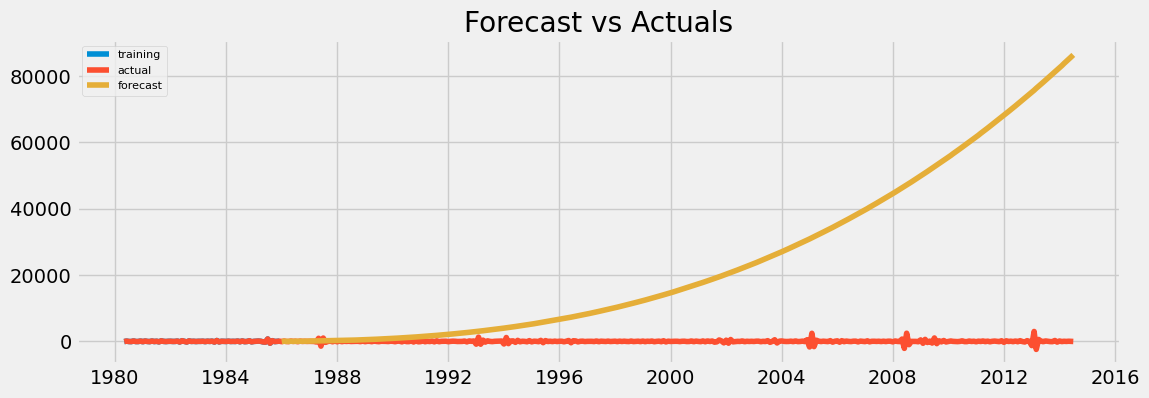

In [89]:
model = ARIMA(train, order=(2,4,3))  # Replace p, d, and 3 with appropriate values
# p is the significant values ( I chose the number of higher lines on my autocorrelation)
# d is the number of differencing attempts ( I am usng the 4th attempt because that had best p-vaue)
# q is the number of values outside of the blue area on the autocorrelation chart
fitted = model.fit()
print(fitted.summary())

# Forecast
forecast_steps = len(test)
fc = fitted.forecast(steps=forecast_steps, alpha=0.05)  # Forecasted values

# Compute standard errors
se = np.sqrt(fitted.forecast(steps=forecast_steps, alpha=0.05)[1])  # Standard errors

# Compute confidence interval
conf = 1.96 * se  # 95% confidence interval (for a two-sided interval)

# Create forecasted and confidence interval series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(fc - conf, index=test.index)
upper_series = pd.Series(fc + conf, index=test.index)

# Plot
plt.figure(figsize=(12, 4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('ARIMA_forecast_vs_actuals.png')
plt.show()

### iterating

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   68
Model:                 ARIMA(3, 4, 1)   Log Likelihood                -457.607
Date:                Sun, 11 Aug 2024   AIC                            925.214
Time:                        20:26:29   BIC                            936.008
Sample:                    05-01-1980   HQIC                           929.466
                         - 12-01-1985                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9330      0.060    -32.047      0.000      -2.051      -1.815
ar.L2         -1.7288      0.124    -13.971      0.000      -1.971      -1.486
ar.L3         -0.7248      0.133     -5.451      0.0

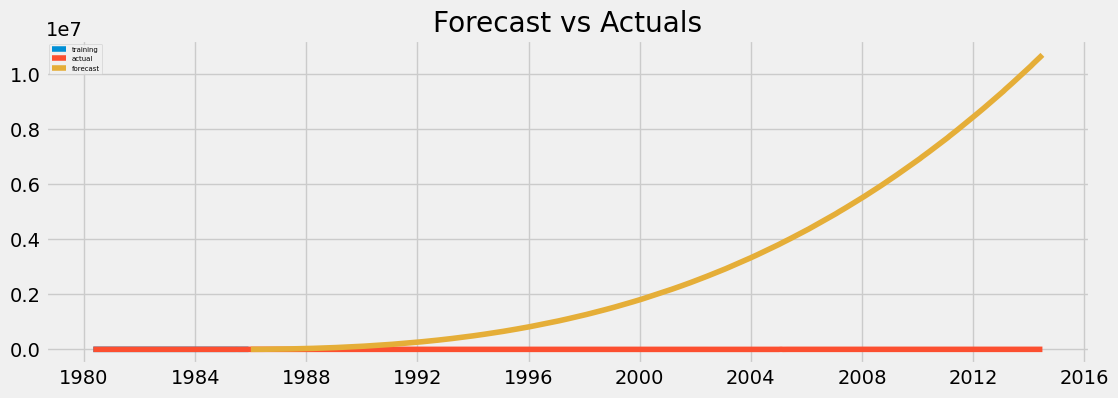

In [90]:
model = ARIMA(train, order=(3,4,1))  # Replace p, d, and q with appropriate values
fitted = model.fit()
print(fitted.summary())

# Forecast
forecast_steps = len(test)
fc = fitted.forecast(steps=forecast_steps, alpha=0.05)  # Forecasted values

# Compute standard errors
se = np.sqrt(fitted.forecast(steps=forecast_steps, alpha=0.05)[1])  # Standard errors

# Compute confidence interval
conf = 1.96 * se  # 95% confidence interval (for a two-sided interval)

# Create forecasted and confidence interval series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(fc - conf, index=test.index)
upper_series = pd.Series(fc + conf, index=test.index)

# Plot
plt.figure(figsize=(12, 4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=5)

plt.savefig('iterating.png')
           
plt.show()

### All coefficients are significant, p-values all at 0.0, but the forecast line does not line up wth the plot line

                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   68
Model:                 ARIMA(3, 4, 0)   Log Likelihood                -483.872
Date:                Sun, 11 Aug 2024   AIC                            975.744
Time:                        20:27:07   BIC                            984.380
Sample:                    05-01-1980   HQIC                           979.146
                         - 12-01-1985                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.0853      0.099    -21.083      0.000      -2.279      -1.891
ar.L2         -1.9372      0.196     -9.862      0.000      -2.322      -1.552
ar.L3         -0.8219      0.145     -5.660      0.0

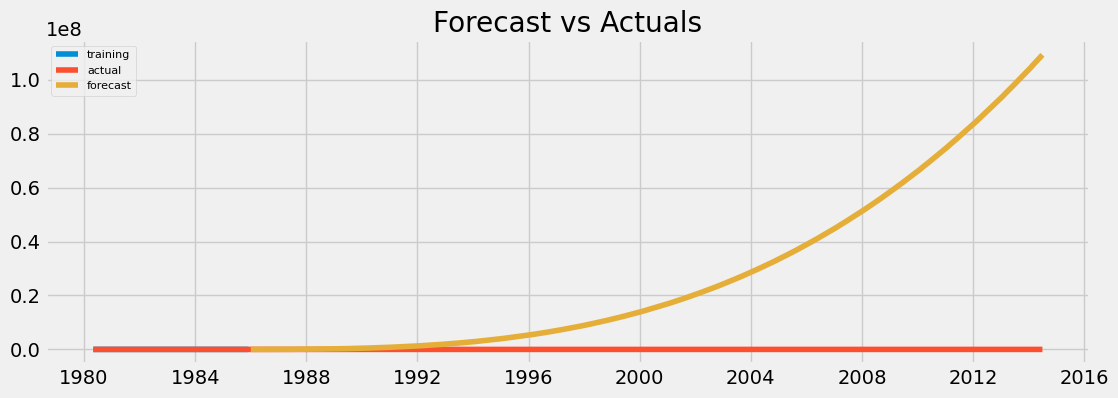

In [91]:
#try again wtih reducing my p and q values:

# model = ARIMA(train, order=(2,4,3)) (comparing with previous values)
model = ARIMA(train, order=(3,4,0))  # Replace p, d, and q with appropriate values
fitted = model.fit()
print(fitted.summary())

# Forecast
forecast_steps = len(test)
fc = fitted.forecast(steps=forecast_steps, alpha=0.05)  # Forecasted values

# Compute standard errors
se = np.sqrt(fitted.forecast(steps=forecast_steps, alpha=0.05)[1])  # Standard errors

# Compute confidence interval
conf = 1.96 * se  # 95% confidence interval (for a two-sided interval)

# Create forecasted and confidence interval series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(fc - conf, index=test.index)
upper_series = pd.Series(fc + conf, index=test.index)

# Plot
plt.figure(figsize=(12, 4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

### same results with forecast line increasing and actual values staying fixed at 0.  P-values still good.